In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
from matplotlib.ticker import LinearLocator
# alpha = latency, units are in s
# beta = 1/bandwidth, units of bandwiths is in GB/s
# P = number of processors in the entire system, units are in numbers :)
# N = message size, units are in GB
# gamma = number of processors in a group in Tencent's AllReduce


In [2]:
# %matplotlib inline  
# %matplotlib widget
# %pylab

In [3]:
LT = 1e-5 #in seconds
BW = 26843545600 #50GB/s, in bytes/second

#HammingMesh, 400Gb/s = 50GB/s

In [4]:
def Torus2D_Google(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 4*alpha*(np.sqrt(P)-1) + 4*beta*N*(np.sqrt(P)-1)/np.sqrt(P)

def Dragonfly_Hierarchical_dimensionPipelined(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    p_hat = np.sqrt(np.sqrt(1+4*P)-1)/2
    return alpha*(2*np.log2(p_hat)+5*p_hat-3) + beta*N + 2*np.sqrt(alpha*beta*N*(2*np.log2(p_hat)+5*p_hat-3))

def Dragonfly_Hierarchical_dimensionNotPipelined(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    p_hat = np.sqrt(np.sqrt(1+4*P)-1)/2

    R_stage = alpha*(np.log(p_hat)-1) + beta*N + 2*np.sqrt(max((np.log(p_hat)-1)*beta*N*alpha,0))
    L_stage = alpha*(2*p_hat-1) + beta*(2*p_hat-1)*N
    G_stage = p_hat*alpha + p_hat*beta*N
    return R_stage+L_stage+G_stage+L_stage+R_stage

def Dragonfly_proposed(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    p_hat = np.sqrt(np.sqrt(1+4*P)-1)/2
    return alpha*(7*p_hat-4)+beta*N*(7*p_hat-4)/p_hat

def Ring(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 2*(P-1)*alpha + 2*beta*N*(P-1)/P

def RingDropped(latency, bandwidth, P, N, X=1):
    alpha = latency
    beta = 1/bandwidth
    return (P-1)*alpha + beta*N*(P-1)/P + (P-X-1)*alpha + beta*N*(P-X-1)/(P-X)

def Tree(latency, bandwidth, P, N): 
    alpha = latency
    beta = 1/bandwidth
    return 2*alpha*(np.log2(P)-1) + 2*beta*N + 4*np.sqrt((np.log2(P)-1)*beta*N*alpha)

def DoubleTree(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return alpha*(2*np.log(P)-1) + beta*N + np.sqrt(4*beta*N*alpha*(2*np.log(P)-1))

def Rabenseifner(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 2*np.log2(P)*alpha + 2*beta*N*(P-1)/P

def BiRing(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 2*(P-1)*alpha + beta*N*(P-1)/P

def BiRingHier(latency, bandwidth, P, N):
    groupSize = 544
    alpha = latency
    beta = 1/bandwidth

    l_cost = 2*alpha*(groupSize-1)+beta*N*(groupSize-1)/groupSize
    g_cost = 2*alpha*(2*P/groupSize -1 ) + beta*N*(2*P/groupSize-1)/(2*P/groupSize)

    return 2*l_cost+g_cost


In [14]:
def sweepProcessors(algos, N=20*2**20, Ps=np.arange(4, 1024, 1)):
    results = {}
    for p in Ps:
        for key in algos:
            if key not in results.keys():
                results[key]=[algos[key](LT, BW, p, N)]
            else:
                results[key].append(algos[key](LT, BW, p, N))
    return results, Ps, ["Sweeping Number of Processors", "Processors", "Communication Time (s)"]

def sweepProcessorsThesis(N=25*2**20, Ps=np.arange(4,256,1)):
    results = {"Full Ring":[], "Ring, X=25%":[], "Ring, X=50%":[]}
    for p in Ps:
        results["Full Ring"].append(Ring(LT, BW, p, N))
        results["Ring, X=25%"].append(RingDropped(LT, BW, p, N, X=int(0.25*p)))
        results["Ring, X=50%"].append(RingDropped(LT, BW, p, N, X=int(0.5*p)))
    return results, Ps, ["Sweeping Number of Processors, Message Size = {} bytes".format(N), "Processors", "Communication Time (s)"]


def sweepMessageSize(algos, P=256, Ns=np.arange(2*2**20, 2*2**30, 2*2**20)):
    runtime = {}    
    for n in Ns:
        for key in algos:
            t = algos[key](LT, BW, P, n)

            if key not in runtime.keys():
                runtime[key]=[t]
            else:
                runtime[key].append(t)         
    return runtime, Ns, ["Sweeping message size", "Message size", "Communication Time (s)"]

def getThroughput(algos, P=256, Ns=np.arange(2*2**20, 2*2**30, 2*2**20)):
    throughput = {}
    for n in Ns:
        for key in algos:
            t = algos[key](LT, BW, P, n)

            if key not in throughput.keys():
                throughput[key]=[n/t]
            else:
                throughput[key].append(n/t)
    return throughput, Ns, ["Sweeping msg size", "Message size (bytes)", "Throughput (bytes/sec)"]

In [15]:
def plotData(results, x_axis, PlotInfo):
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(111)
    
    # ax.set_xscale('log', base=2)

    plt.tight_layout()
    plt.title(PlotInfo[0], fontsize=20)
    plt.xlabel(PlotInfo[1], fontsize=20)
    plt.ylabel(PlotInfo[2], fontsize=20)

    for key in results:
        ax.plot(x_axis, results[key], label=key)
    plt.legend()
    plt.show()

### some experiments

In [32]:
results, x_axis, plotInfo = sweepProcessorsThesis(N=500*2**20, Ps=np.arange(4,17,1))

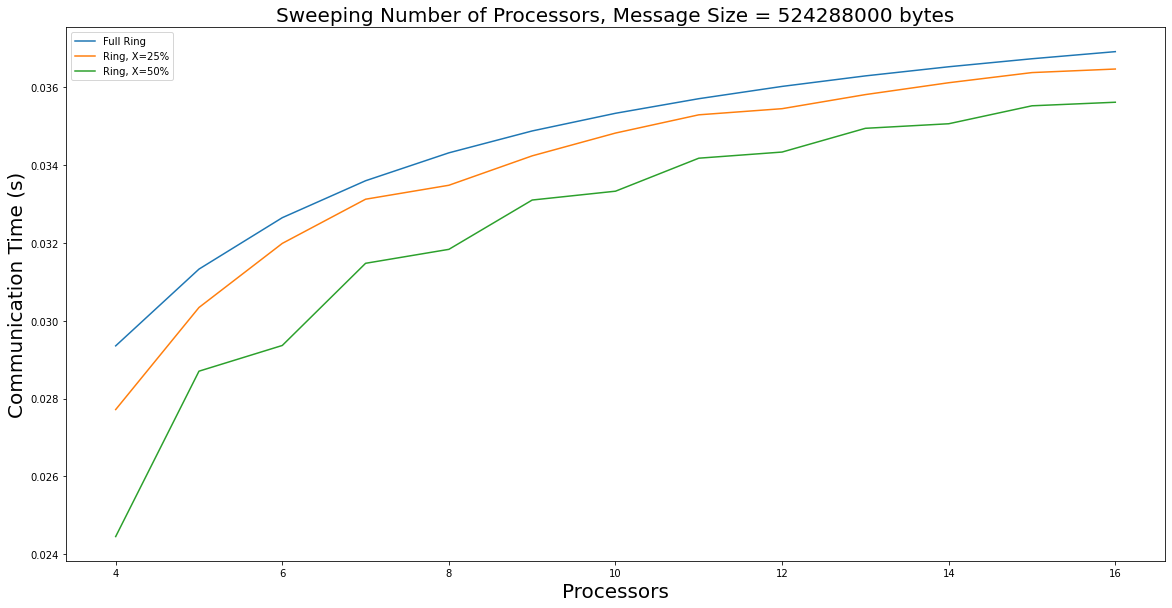

In [33]:
plotData(results, x_axis, plotInfo)

In [ ]:
algos = { 
        # "Dragonfly, hierearchical AR with no dimension pipelining": Dragonfly_Hierarchical_dimensionNotPipelined,
        # "Dragonfly_Hierarchical_dimensionPipelined": Dragonfly_Hierarchical_dimensionPipelined,
        # "Dragonfly, hierarchical AR with ring": Dragonfly_proposed,
        "Ring":Ring,
        "Ring Dropped":RingDropped,
        # "Torus2D AR":Torus2D_Google,
        } 

In [ ]:
results, x_axis, plotInfo = sweepProcessors(algos, N=25*2**20, Ps=np.linspace(4, 16, 12))

In [ ]:
plotData(results, x_axis, plotInfo)

In [ ]:
runtime, msg_size, plotInfo = sweepMessageSize(algos, P=1024, Ns = np.arange(2**20, 2**30, 2**20))

In [ ]:
plotData(runtime, msg_size, plotInfo)

In [ ]:
thrpt, x_axis, plotInfo = getThroughput(algos, P=16320, Ns=np.arange(2**20, 2**30, 200*2**20))

In [ ]:
plotData(thrpt, x_axis, plotInfo)

## 3D plot with P and N

In [ ]:
def getMatrix(algos, algo, messages=np.logspace(17,33,num=16, base=2), procs=np.logspace(2,18, num=16,base=2)):
    #convention: rows = processors, cols = messages
    matrix = np.zeros((procs.size, messages.size))
    X,Y = np.meshgrid(procs, messages)
    for p_i in range(procs.size):
        for n_i in range(messages.size):
            matrix[p_i][n_i] = algos[algo](LT, BW, procs[p_i], messages[n_i])
    return matrix, X, Y    

In [ ]:
ring_matrix, X, Y = getMatrix(algos, "Ring", messages=np.linspace(1*2**20, 1*2**30, 100), procs = np.linspace(4, 1024, 100))
tree_matrix, X, Y = getMatrix(algos, "Tree", messages=np.linspace(1*2**20, 1*2**30, 100), procs = np.linspace(4, 1024, 100))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, tree_matrix-ring_matrix)
ax.plot_surface(X,Y, np.zeros_like(ring_matrix))
ax.set_xlabel("Processors", fontsize=20)
ax.set_ylabel("Message Size", fontsize = 20)
ax.set_zlabel("Communication Time(s)", fontsize = 20)
plt.show()

In [ ]:
diff_matrix = tree_matrix - ring_matrix

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(diff_matrix)

In [ ]:
"add %"